## Analyzing Police Logs - City of Brockton, MA


In [545]:
import pandas as pd
import numpy as np
import tabula
import re
import datetime

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import os
from os import listdir
from os.path import isfile, join

import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap, HeatMapWithTime

** Gather Data **

In [546]:
def fetch_logs(month, year, dir='logs'):
    url = "http://www.brocktonpolice.com/wp-content/uploads/{}/{}/".format(year, month)    
    folder_location = os.path.join(dir, year, month)
    if not os.path.exists(folder_location):os.makedirs(folder_location)
    
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")     
    for link in soup.select("a[href$='.pdf']"):
        # Name the pdf files using the last portion of each link which are unique in this case
        filename = os.path.join(folder_location,link['href'].split('/')[-1])
        print('Downloading {}...'.format(filename)) # TODO: remove, testing purpose
        with open(filename, 'wb') as f:
            f.write(requests.get(urljoin(url,link['href'])).content)

def parse_logs(verbose=False):
    path = 'logs'
    files = [f for f in listdir(path) if isfile(join(path, f))]
    calls = pd.DataFrame(columns=call_columns)
    
    for root, dirs, files in os.walk("logs"):
        dirs.sort()
        files.sort()
        path = root.split(os.sep)

        if verbose:
            print("* Checking directory: {}".format(root))
        
        for i in range(len(files)):
            file = files[i]
            file_path = os.path.join(root, file)

            if not is_valid_file(file):
                continue
            
            if verbose:
                print("** Parsing: {}, {}/{}".format(file, i, len(files)))
                
            file_name = file.split(".")[0]
            date = get_date_from_name(file_name)
            pages = tabula.read_pdf(file_path, pages='all')
            file_calls = parse_pages(pages)
            file_calls['Date'] = date
            calls = calls.append([file_calls], ignore_index = True) 
    
    return calls

def parse_pages(pages):
    page_columns = ['Column', 'Value', 'Action']
    short_page_columns = ['Column', 'Value/Action']
    calls = pd.DataFrame(columns=call_columns)
    
    for i in range(len(pages)):
        page = pages[i]
        is_short_page = False
        
        if 'Unnamed: 0' in page:
            page.drop('Unnamed: 0', axis=1, inplace=True) # provides no data

        if len(page.columns) < 2 or len(page.columns) > 3:
            continue
            
        if len(page.columns) == 2:
            is_short_page = True
            
        columns = short_page_columns if is_short_page else page_columns    

        # save current columns
        prev_columns = page.columns.tolist()
        page.columns = columns

        # append original columns as an entry 
        df_prev_columns = pd.DataFrame([prev_columns], columns=columns)
        updated_page = page.append(df_prev_columns, ignore_index=True)
        updated_page.fillna("None", inplace=True)

        entry_values = None

        for index, row in updated_page.iterrows():
            column_name = str(row[columns[0]])
            column_value = row[columns[1]]

            if is_new_call(column_name):
                if index > 0 and entry_values != None:
                    # add previous call as entry before we parse new call
                    call = pd.DataFrame([entry_values.values()], columns=call_columns)
                    calls = calls.append([call], ignore_index = True) 

                entry_values = {column: None for column in call_columns}
                entry_values['Call Number'] = get_call_number(column_name)
                entry_values['Call Time'] = get_call_time(column_name)
                
                if is_short_page:
                    # reason and action values combined in short pages
                    reason_action = get_reason_action(column_value)
                    
                    if reason_action != None:
                        entry_values['Reason'], entry_values['Action'] = reason_action
                    else:    
                        # unable to split reason and action
                        entry_values['Reason'] = column_value
                        entry_values['Action'] = column_value
                else:
                    action = row[columns[2]]
                    entry_values['Reason'] = column_value
                    entry_values['Action'] = action                    
            else:
                # TODO: find better approach to parsing pages when first row isn't a call number    
                if entry_values == None or entry_values['Call Number'] == None:
                    continue
                    
                filter_column_name = column_name.replace(":", "")
                if filter_column_name in entry_values:
                    entry_values[filter_column_name] = column_value
    return calls             

** Utils **

In [547]:
def get_call_types(path):
    with open(path) as f:
        return f.read().splitlines()
    
def is_valid_file(filename):
    pattern = re.compile("^(\d{8}.pdf)$")
    return bool(pattern.match(filename))

def get_date_from_name(filename):
    return re.sub("[^0-9]", "", filename)
    
def get_call_number(str):
    return str[:-4].strip()

def get_call_time(str):
    return str[-4:].strip()

def is_new_call(str):
    pattern = re.compile("^(\d\d-[\d]+)$")
    return bool(pattern.match(str))

def get_reason_action(text):
    for type in call_types:
        updated_type = type.strip().lower()
        res = re.search(r'\b({})\b'.format(updated_type), text.lower())
        if res != None:
            action = text[len(updated_type):]
            return (type, action.strip())
    return None  

def get_hour(dateTime):
    return dateTime.hour

def get_month(dateTime):
    return dateTime.month

def get_dayOfWeek(dateTime):
    return dateTime.weekday()

def format_street_name(street):
    return re.sub("(\[BRO\s*[A-Za-z0-9]*\])", "", street).strip()
    
def format_address(street):
    if street == None: return
    street = format_street_name(street)
    return "{}, BROCKTON, MA".format(street)

def get_postal(df, reverse):
    location_info = reverse((df['Latitude'], df['Longitude']), language='en')
    address_map = location_info.raw['address']
    if 'postcode' in address_map:
        return address_map['postcode']
    else:
        return None
    
def get_locations(df, reason, count=10):
    reason_df = df[df['Reason'] == reason]
    return reason_df.groupby('Address').size().sort_values(ascending = False).head(count)
  
# Visualization     
def show_locations(df, reason, count=10):
    return locations_for_reason(df, reason, count).sort_values().plot(kind='barh')

def show_hourly_occurrence(df, reason):
    df[df['Reason'] == reason].groupby('Hour').size().plot(kind='bar') 

def show_monthly_occurrence(df, reason):
    df[df['Reason'] == reason].groupby('Month').size().plot(kind='bar') 
    
def show_month_hour_occurrence(df, reason):
    reason_df = df[df['Reason'] == reason]
    reason_df.groupby(['Month','Hour']).size().unstack(0).plot(subplots=True, kind = 'bar', figsize = (5, 30))                                                               
                                                               
def get_map():
    return folium.Map(location = [42.083431, -71.018379],
                     tiles='cartoDB dark_matter',
                     zoom_start=12)

def display_map(map_df):
    map = get_map()
    map_df.apply(lambda row: folium.CircleMarker(location = [row['Latitude'], row['Longitude']]).add_to(map), axis=1)
    return map

def display_cluster_map(map_df):
    map = get_map()
    FastMarkerCluster(data=list(zip(map_df['Latitude'].values, map_df['Longitude'].values))).add_to(map)
    folium.LayerControl().add_to(map)
    return map

def display_cluster_for_reason(df, reason):
    filter_df = df[df['Reason'] == reason]
    filter_df = filter_df[pd.notnull(filter_df['Latitude'])]
    return display_cluster_map(filter_df)

def display_heatmap_for_reason(df, reason):
        filter_df = df[df['Reason'] == reason]
        filter_df = filter_df[pd.notnull(filter_df['Latitude'])]
        
        heat_df = filter_df[['Latitude', 'Longitude']]
        heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]
        
        map = get_map()
        HeatMap(heat_data, radius=15).add_to(map)
        return map
    
def display_time_heatmap_for_reason(df, reason):
    filter_df = df[df['Reason'] == reason]
    filter_df = filter_df[pd.notnull(filter_df['Latitude'])]

    df_month_list = []
    for month in filter_df.Month.sort_values().unique():
        df_month_list.append(filter_df.loc[filter_df.Month == month, ['Latitude', 'Longitude']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())
    
    map = get_map()
    HeatMapWithTime(df_month_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(map)
    return map

In [548]:
call_types = get_call_types('call_types')
call_columns = ['Call Number', 'Call Time', 'Call Taker', 'Reason', 'Action', 'ID', 'Location/Address', 'Date']
weekday_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

### Data Setup / Cleanup

In [549]:
# parse logs and persist result
# calls = parse_logs(True)
# calls.to_pickle('cached_calls.pkl')

# read data from cache
calls = pd.read_pickle('cached_calls.pkl')

In [550]:
# remove any missing values or duplicates
calls.dropna(inplace=True)
calls.drop_duplicates(subset=['Call Number'], inplace=True)

** Set date and time ** 

In [551]:
calls['timeStamp'] = pd.to_datetime(calls['Date'] + ' ' + calls['Call Time'], errors='coerce')
calls['Hour'] = calls['timeStamp'].apply(lambda time: time.hour)
calls['Month'] = calls['timeStamp'].apply(lambda time: time.month)
calls['Day of Week'] = calls['timeStamp'].apply(lambda time: time.dayofweek)
calls['Day of Week'] = calls['Day of Week'].map(weekday_map)

** Get location info (address, lat, lng) ** 

In [552]:
calls.rename(columns={"Location/Address": "Street"}, inplace=True)
calls['Address'] = calls['Street'].apply(lambda x: format_address(x))

In [553]:
# read cached location data
try:
    cached_locations = pd.read_pickle('cached_locations.pkl')
except (FileNotFoundError) as e:
    cached_locations = pd.DataFrame(columns = ['Address']) 

# get list of addresses from calls not in cache    
cached_address = cached_locations["Address"].tolist()
call_address = calls['Address'].unique()
query_address = [address for address in call_address if address not in cached_address]
locations = pd.Series(query_address, name='Address').to_frame()

In [186]:
# fetch lat, lng
locator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
locations['Location'] = locations['Address'].apply(geocode)

locations['Point'] = locations['Location'].apply(lambda loc: tuple(loc.point) if loc else None)
locations.dropna(inplace=True)

locations[['Latitude', 'Longitude', 'Altitude']] = pd.DataFrame(locations['Point'].tolist(), index=locations.index)
locations.drop('Altitude', axis=1, inplace=True)

In [218]:
# get postal code
reverse = RateLimiter(locator.reverse, min_delay_seconds=1)
locations['PostalCode'] = locations.apply(get_postal, axis=1, reverse=reverse)

In [558]:
# merge with cache data and save
if cached_locations.empty:
    locations.to_pickle('cached_locations.pkl')
else:
    locations = pd.concat([cached_locations, locations], ignore_index=True)
    locations.to_pickle('cached_locations.pkl')

In [560]:
calls = pd.merge(calls,locations,how='left',on='Address')

### Exploratory Data Analysis

** Top 5 officers reporting to incidents ** 

In [561]:
calls['ID'].value_counts().head(5)

Patrolman Richard J Gaucher      1450
Patrolman David F Santos          961
Patrolman Joe C Miranda           681
Patrolman Franck B Coulanges      656
Patrolman Alexander C Burrell     642
Name: ID, dtype: int64

** Top 5 incident locations/address **

In [562]:
calls['Address'].value_counts().head(5)

470 FOREST AVE, BROCKTON, MA     412
200 WESTGATE DR, BROCKTON, MA    387
105 BELAIR ST, BROCKTON, MA      244
54 N MAIN ST, BROCKTON, MA       195
7 COMMERCIAL ST, BROCKTON, MA    191
Name: Address, dtype: int64

** Most common actions **

In [563]:
calls['Action'].value_counts().head(5)

Matter Settled             8516
FALSE ALARM                3747
Report taken               3660
Citation/Warning Issued    3231
False 911 Call             3077
Name: Action, dtype: int64

** Most common incidents **

In [564]:
calls['Reason'].value_counts().head(5)

MOTOR VEHICLE STOP    5524
DISTURBANCE           5202
Alarm Telephone       3717
M V A                 2917
911 Verify Call       2692
Name: Reason, dtype: int64

** Most common action taken per incident type ** 

In [565]:
calls.groupby('Reason')['Action'].apply(lambda x: x.value_counts().index[0]).reset_index()

,Reason,Action
0,911 False Call,False 911 Call
1,911 Hang Up,False 911 Call
2,911 Unknown Emergency,False 911 Call
3,911 Verify Call,False 911 Call
4,A & B Dangerous Weapon Gun Hot Sheet,A & B Dangerous Weapon Gun Hot Sheet
...,...,...
213,VANDALISM,Report taken
214,Vehicle Fire,Matter Settled
215,Water Ban Violation Citation/Warning Issued,Water Ban Violation Citation/Warning Issued
216,Water Ban Violation Clear No Action Needed,Water Ban Violation Clear No Action Needed


** Most common incident by location/address **

In [566]:
location_incident_df = calls.groupby('Address')['Reason'].apply(lambda x: x.value_counts().index[0]).reset_index()
location_incident_df['Count'] = calls.groupby('Address')['Reason'].apply(lambda x: x.value_counts()[0]).values
location_incident_df.sort_values(by='Count', ascending=False, inplace=True)
location_incident_df.head(10)

,Address,Reason,Count
10132,"470 FOREST AVE, BROCKTON, MA",TRAFFIC CONTROL,257
763,"105 BELAIR ST, BROCKTON, MA",Community Police Call,191
12936,"715 BELMONT ST, BROCKTON, MA",TRAFFIC CONTROL,125
14704,"917 MONTELLO ST, BROCKTON, MA",MISSING PERSON,118
12825,"700 BELMONT ST, BROCKTON, MA",TRAFFIC CONTROL,89
11001,"54 N MAIN ST, BROCKTON, MA",DISTURBANCE,80
13273,"75 MONTELLO ST @ 74 CENTRE ST, BROCKTON, MA",MOTOR VEHICLE STOP,73
12552,"680 CENTRE ST, BROCKTON, MA",DISTURBANCE,66
7320,"308 MONTELLO ST, BROCKTON, MA",Alarm Telephone,65
4744,"200 WESTGATE DR, BROCKTON, MA",Alarm Telephone,62


### Data Visualization 

In [225]:
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline

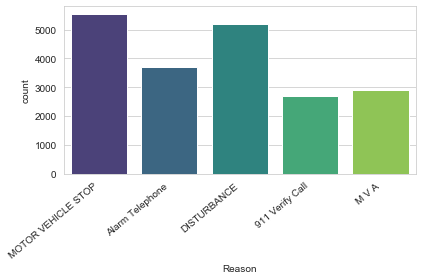

In [226]:
top_reasons_list = calls['Reason'].value_counts().head(5).index.tolist()
top_reasons_df = calls[calls['Reason'].isin(top_reasons_list)]
ax = sns.countplot(x='Reason',data=top_reasons_df,palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

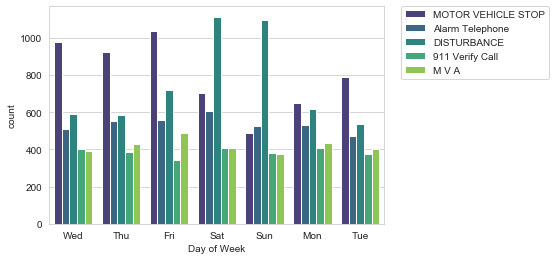

In [78]:
sns.countplot(x='Day of Week',data=top_reasons_df,hue='Reason',palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

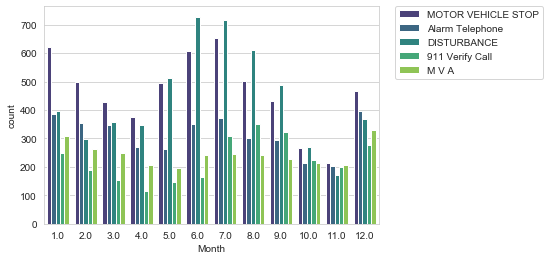

In [81]:
sns.countplot(x='Month',data=top_reasons_df,hue='Reason',palette='viridis')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

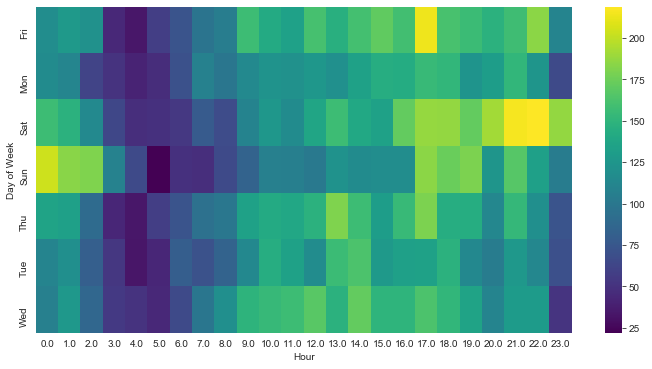

In [85]:
dayHour = top_reasons_df.groupby(by=['Day of Week','Hour']).count()['Reason'].unstack()
plt.figure(figsize=(12,6))
sns.heatmap(dayHour,cmap='viridis')

** Individual incident analysis **

In [237]:
get_locations(calls, 'Overdose')

Address
54 N MAIN ST, BROCKTON, MA            20
N MAIN ST, BROCKTON, MA               11
30 N MAIN ST, BROCKTON, MA             4
64 N MONTELLO ST, BROCKTON, MA         4
10 COMMERCIAL ST, BROCKTON, MA         4
63 MAIN ST, BROCKTON, MA               4
113 GREEN ST Apt. #1, BROCKTON, MA     3
65 WESTGATE DR, BROCKTON, MA           3
83 SOUTHWORTH ST, BROCKTON, MA         3
52 N MAIN ST, BROCKTON, MA             3
dtype: int64

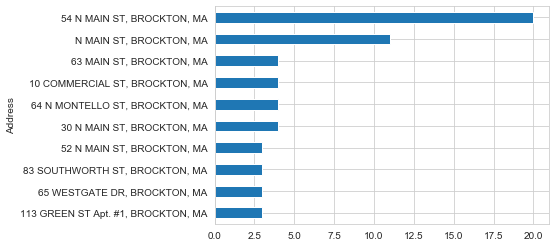

In [236]:
show_locations(calls, 'Overdose')

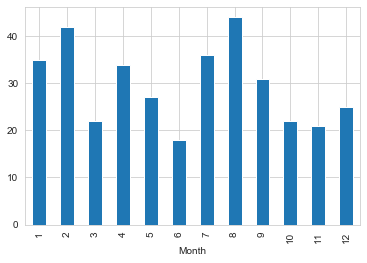

In [243]:
show_monthly_occurrence(calls, 'Overdose')

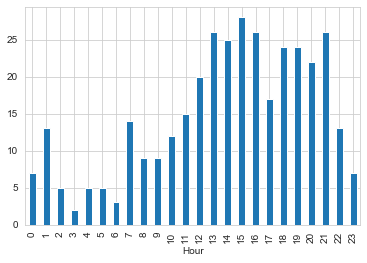

In [241]:
show_hourly_occurrence(calls, 'Overdose')

In [256]:
map_df = calls[pd.notnull(calls['Latitude'])]
display_heatmap_for_reason(map_df, 'Overdose')

### Predicting Incidents with ML

In [524]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [525]:
incidents = calls[(calls.timeStamp.dt.year > 2018) & (calls.timeStamp.dt.month < 11)]
incidents = incidents[['Day of Week', 'PostalCode', 'Hour']]
incidents = incidents.dropna()

drop_idx = incidents[(incidents['PostalCode'] == '17925') | (incidents['PostalCode'] == 'N0G 2V0')].index
incidents = incidents.drop(drop_idx)

incidents.loc[:, 'Incidents'] = 1
incidents = incidents.groupby(['Day of Week', 'PostalCode', 'Hour']).sum().reset_index()
incidents = incidents[['Incidents', 'Hour', 'Day of Week', 'PostalCode']]

dayOfWeek = pd.get_dummies(incidents['Day of Week'], drop_first=True)
postalCodes = pd.get_dummies(incidents['PostalCode'], drop_first=True)
incidents.drop(['Day of Week', 'PostalCode'],axis=1,inplace=True)
incidents = pd.concat([incidents,dayOfWeek, postalCodes],axis=1)

X_train, X_test, y_train, y_test = train_test_split(incidents.drop('Incidents',axis=1), 
                                                    incidents['Incidents'], test_size=0.30)

#### Linear Regression

In [526]:
from sklearn.linear_model import LinearRegression

In [527]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm.score(X_test, y_test)

0.715627248365974

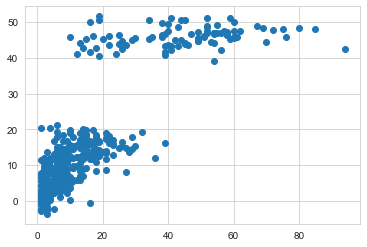

In [528]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

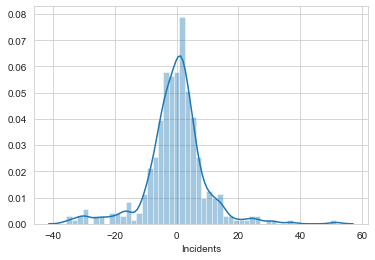

In [529]:
sns.distplot((y_test-predictions),bins=50);

In [530]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 6.421650294144186
MSE: 93.45435663784411
RMSE: 9.667179352729736


#### K Nearest Neighbors

In [531]:
from sklearn.neighbors import KNeighborsRegressor

In [532]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
knn.score(X_test, y_test)

0.7201768264678252

#### Random Forest

In [533]:
from sklearn.ensemble import RandomForestRegressor

In [534]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8935067851024338

In [535]:
list(zip(incidents.columns, rf.feature_importances_))

[('Incidents', 0.20678353776984643),
 ('Hour', 0.006568771027410552),
 ('Mon', 0.013884324299637051),
 ('Sat', 0.019020315699777402),
 ('Sun', 0.006889758028161929),
 ('Thu', 0.006779076739315023),
 ('Tue', 0.007750403547422474),
 ('Wed', 0.342784491315978),
 ('02301', 0.016005542212887896),
 ('02302', 0.3425623044627248),
 ('02303', 9.366459451956136e-05),
 ('02322', 0.0),
 ('02343', 2.5394633651534707e-05),
 ('02356', 0.0014547323027991883),
 ('02357', 0.0024392647555568515),
 ('02379', 0.014845317939830668),
 ('02401', 0.0012957570136773084),
 ('02402', 0.010817343656803315)]

#### SVM

In [537]:
from sklearn.svm import SVR

In [544]:
svm = SVR()
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

-0.02354919471477368